In [1]:
import gc, os, time
from collections import deque
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

%matplotlib inline

# Data Loading

Here I load the data given to us in the competition. It is stored in a folder called data, that exists in top level folder together with this notebook.

In [216]:
def load_sales(parse_date = True):
    data_fol = 'data'
    sales = pd.read_csv(os.path.join(data_fol, 'sales_train.csv'))
    if parse_date:
        date_col = pd.to_datetime(sales.date, format='%d.%m.%Y')
        sales.date = date_col
        sales['Month'] = sales.date.dt.to_period('M')
    return sales

def aggregate_monthly(sales_df):
    assert 'Month' in sales_df.columns, 'Month column not found'
    return (sales_df
            .groupby(['Month', 'shop_id', 'item_id'])
            .agg({'item_cnt_day': np.sum, 'item_price': np.mean})
            .rename(columns={'item_cnt_day':'item_cnt_month'})
           )

In [217]:
def load_all():
    sales = load_sales()
    agg_sales = aggregate_monthly(sales)
    items = pd.read_csv('data/items.csv')
    categories = pd.read_csv('data/item_categories.csv')
    test_set = pd.read_csv('data/test.csv')
    return sales, agg_sales, items, categories, test_set

In [218]:
sales, agg_sales, items, categories, test_set = load_all()

# Exploratory Data Analysis

In this section, I look at the data, and try to derive insight for later use in feature generation, as well as correct any possible mistakes/outliers.

## Look at raw data

In [ ]:
sales.head()

In [220]:
sales.item_cnt_day.describe()

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

In [224]:
sales.item_cnt_day.sort_values()

1057907     -22.0
1835454     -16.0
2048519      -9.0
59156        -6.0
940092       -6.0
            ...  
2608040     624.0
2851091     637.0
2864235     669.0
2326930    1000.0
2909818    2169.0
Name: item_cnt_day, Length: 2935849, dtype: float64

In [227]:
sales[sales.item_cnt_day >= 1000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Month
2326930,2015-01-15,24,12,20949,4.000000,1000.0,2015-01
2909818,2015-10-28,33,12,11373,0.908714,2169.0,2015-10


In [242]:
sales[sales.item_id == 11373].item_cnt_day.value_counts().sort_index()

1.0       93
2.0       70
3.0       47
4.0       44
5.0       32
6.0       34
7.0       16
8.0       17
9.0        5
10.0      13
11.0      11
12.0       8
13.0      12
14.0       6
15.0       4
16.0       4
18.0       4
20.0       3
21.0       1
22.0       6
23.0       3
24.0       1
25.0       1
26.0       1
27.0       3
28.0       3
30.0       1
31.0       2
32.0       1
33.0       1
38.0       1
41.0       2
46.0       1
51.0       1
54.0       1
58.0       1
61.0       1
65.0       1
84.0       1
95.0       1
97.0       1
105.0      1
108.0      1
242.0      1
539.0      1
2169.0     1
Name: item_cnt_day, dtype: int64

In [235]:
items.query('item_id == 11373')

,item_name,item_id,item_category_id
11373,Доставка до пункта выдачи (Boxberry),11373,9


google: 'Доставка до пункта выдачи (Boxberry)' --> 'Delivery to the point of issue (Boxberry)'

In [239]:
items.query('item_id == 20949').item_name.values

array(['Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм'],
      dtype=object)

google: 'Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм' --> 'Branded jersey package 1C Interest white (34'42) 45 microns'

In [248]:
sales[sales.shop_id == 12].item_cnt_day.sort_values()

1057907     -22.0
2048519      -9.0
59156        -6.0
59155        -5.0
1058703      -4.0
            ...  
2626181     539.0
2608040     624.0
2864235     669.0
2326930    1000.0
2909818    2169.0
Name: item_cnt_day, Length: 34694, dtype: float64

## Look at aggregated data

Look at distribution of sales numbers

In [113]:
agg_sales.item_cnt_month.describe()

count    1.609123e+06
mean     2.267201e+00
std      8.649884e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.253000e+03
Name: item_cnt_month, dtype: float64

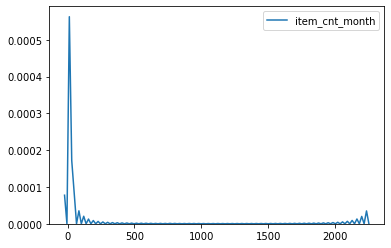

In [116]:
seaborn.kdeplot(agg_sales.item_cnt_month)

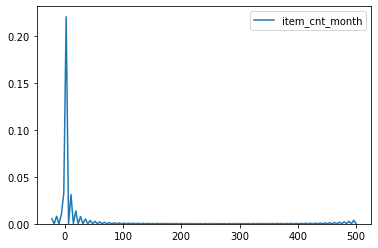

In [117]:
seaborn.kdeplot(np.clip(agg_sales.item_cnt_month,-100, 500))

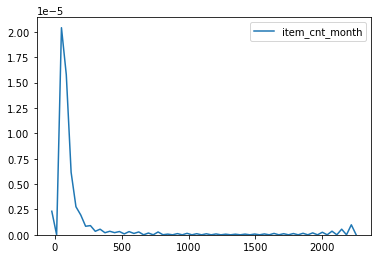

In [119]:
seaborn.kdeplot(agg_sales.item_cnt_month, gridsize=50)

Look at distribution on sales prices

In [169]:
agg_sales.head()

Month    shop_id  item_id
2013-01  0        32         221.0
                  33         347.0
                  35         247.0
                  43         221.0
                  51         128.5
Name: item_price, dtype: float64

In [130]:
price_stats = agg_sales.groupby(level=2).agg(Max=('item_price', 'max'), Min=('item_price', 'min'), Mean=('item_price', 'mean'), STD=('item_price', 'std'))
price_spread = price_stats.Max - price_stats.Min

In [123]:
price_spread.describe()

count    21806.000000
mean       284.625165
std        648.277356
min          0.000000
25%          0.000000
50%        119.000000
75%        299.000000
max      15989.000000
dtype: float64

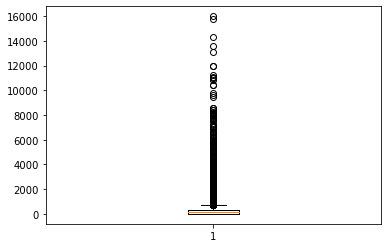

In [124]:
plt.boxplot(price_spread);

In [125]:
price_spread.sort_values(ascending=False).head(10)

item_id
7982     15989.00
7938     15727.33
7983     14291.00
13404    13590.00
13406    13091.00
13401    11989.50
13405    11982.50
14170    11229.00
7942     11072.00
6675     10999.00
dtype: float64

In [128]:
agg_sales.loc[pd.IndexSlice[:,:,7982], :].sort_values(by='item_price')

item_cnt_month  item_price
Month   shop_id item_id                            
2014-12 17      7982                1.0    15001.00
        37      7982                3.0    15046.25
        3       7982                2.0    15091.55
        59      7982                2.0    15091.60
        16      7982                1.0    15092.00
...                                 ...         ...
2015-04 47      7982                1.0    26692.00
2015-02 12      7982                1.0    27490.00
        27      7982                1.0    27490.00
2015-03 46      7982                2.0    28240.00
        54      7982                1.0    30990.00

[151 rows x 2 columns]

In [129]:
agg_sales.loc[pd.IndexSlice[:,:,7938], :].sort_values(by='item_price')

item_cnt_month  item_price
Month   shop_id item_id                            
2015-09 10      7938                1.0     1762.67
2014-05 44      7938                1.0     6798.00
2013-12 30      7938                1.0    11524.00
2013-06 56      7938                1.0    12001.00
2013-12 19      7938                2.0    12199.00
...                                 ...         ...
2013-05 54      7938                1.0    17490.00
        57      7938                2.0    17490.00
2013-04 14      7938                1.0    17490.00
2013-05 5       7938                1.0    17490.00
        25      7938                1.0    17490.00

[188 rows x 2 columns]

In [133]:
normed_var = (price_stats.STD/price_stats.Mean).fillna(0)

In [170]:
normed_var.sort_values()

item_id
0        0.000000
9430     0.000000
9429     0.000000
9428     0.000000
9427     0.000000
           ...   
11856    1.853497
11855    1.927625
11866    2.375067
11872    2.617468
11860    3.184322
Length: 21806, dtype: float64

In [141]:
agg_sales.loc[pd.IndexSlice[:,:,11860], :].sort_index(level=[1,0])

,,,item_cnt_month,item_price
Month,shop_id,item_id,,
2013-06,6,11860,1.0,0.1
2013-07,6,11860,2.0,0.1
2013-08,6,11860,2.0,0.1
2014-01,6,11860,1.0,58.0
2014-02,12,11860,1.0,28.0
2013-06,17,11860,4.0,0.1
2013-07,17,11860,3.0,0.1
2013-08,17,11860,1.0,0.1
2013-06,24,11860,1.0,0.1


In [137]:
items.query('item_id == 11860')

,item_name,item_id,item_category_id
11860,Змей ВАСЯ с цветком 40 см,11860,63


google translate: 'Змей ВАСЯ с цветком 40 см' --> 'SNAKE YOU with a flower 40 cm'

In [143]:
agg_sales.loc[pd.IndexSlice[:,:,11858], :].sort_values(by='item_price')

item_cnt_month  item_price
Month   shop_id item_id                            
2013-07 6       11858               8.0       0.100
2013-06 44      11858               7.0       0.100
        25      11858               4.0       0.100
        26      11858               1.0       0.100
        28      11858               1.0       0.100
...                                 ...         ...
2013-02 6       11858               1.0     139.300
2013-01 37      11858               1.0     139.300
        6       11858               3.0     169.075
        19      11858               1.0     199.000
        8       11858               1.0     199.000

[67 rows x 2 columns]

In [144]:
items.query('item_id == 11858')

,item_name,item_id,item_category_id
11858,Змей ВАСЯ с цветком 22 см,11858,63


google translate: 'Змея ВАСИЛИСА 23 см' --> 'Snake VASILISA 23 cm'

In [147]:
items.query('item_id == 20145')

,item_name,item_id,item_category_id
20145,Удавчик Плюшевый: 75см. (яйцо пластик),20145,63


google translate: 'Удавчик Плюшевый: 75см. (яйцо пластик)' --> 'Boa constrictor Plush: 75cm (egg plastic)'

In [153]:
(agg_sales.item_price == 0.1).sum()

844

In [154]:
(agg_sales.item_price <= 0.1).sum()

943

I think 0.1 is a null value for prices - will replace with median price

In [173]:
agg_sales.loc[agg_sales.item_price <= 0.1, 'item_price'] = np.nan
agg_sales['item_price'] = agg_sales.groupby(level=2).item_price.transform(lambda x: x.fillna(x.mean()))

look at price counts

In [178]:
agg_sales.item_price.value_counts().head(20)

299.0     177451
149.0     160034
199.0     127417
399.0     108742
349.0      56251
249.0      48987
499.0      39628
599.0      37892
999.0      37129
699.0      31261
799.0      29823
99.0       27647
899.0      26610
1199.0     24861
549.0      23323
449.0      22382
1499.0     22229
1999.0     21080
169.0      13261
2599.0     12047
Name: item_price, dtype: int64

TODO: Create and feature, price ends in 9

<br>
<hr>
<br>

Look at distinct number of shops and items

Look at unique values

In [5]:
agg_sales.reset_index()[['Month','shop_id', 'item_id']].nunique()

Month         34
shop_id       60
item_id    21807
dtype: int64

distinct items per month per shop

In [6]:
agg_sales.reset_index().groupby('Month')[['shop_id', 'item_id']].nunique().head()

,shop_id,item_id
Month,,
2013-01,45,8115
2013-02,46,8168
2013-03,46,8302
2013-04,46,8145
2013-05,45,8339


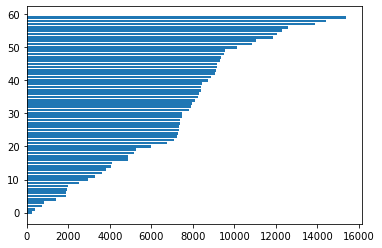

In [7]:
distinct_items_per_shop = agg_sales.reset_index().groupby('shop_id')['item_id'].nunique().sort_values()
plt.barh(range(distinct_items_per_shop.shape[0]), distinct_items_per_shop.values);

Some shops sell alot of items, and some shops sell very few - perhaps I need an encoding for shop id based on how many distinct items that shop sold

In [8]:
distinct_items_per_shop.loc[0]

3600

<br>
<hr>
<br>

Aggregate accross items and shops - and look at temporal behavior

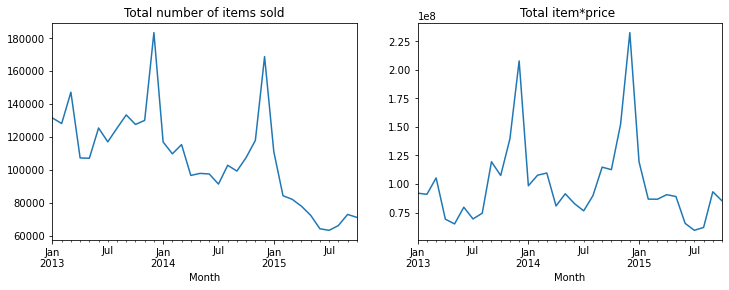

In [9]:
fig, ax  = plt.subplots(1,2)
fig.set_figwidth(12)
agg_sales.groupby(level=0).item_cnt_month.sum().plot(ax=ax[0])
ax[0].set_title('Total number of items sold')
agg_sales.groupby(level=0).apply(lambda x: (x.item_cnt_month*x.item_price).sum()).plot(ax=ax[1])
ax[1].set_title('Total item*price ')
plt.show()

* Decembers are clearly very different from all other months. Will need to either remove, or add a feature for this.
* Also there is a clear difference between summer months and winter months (holidays?)

In [10]:
monthly_agg = agg_sales.groupby(level=0).item_cnt_month.sum()
month_of_year = monthly_agg.reset_index().Month.dt.month.rename('MOY')
month_of_year.index = monthly_agg.index
temp = pd.concat([monthly_agg, month_of_year ], axis=1)

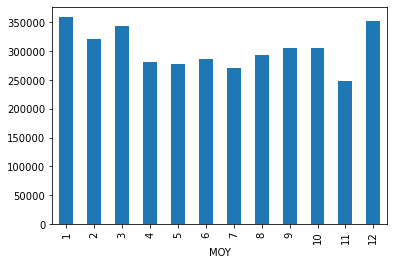

In [11]:
temp.groupby('MOY').item_cnt_month.sum().plot(kind='bar')

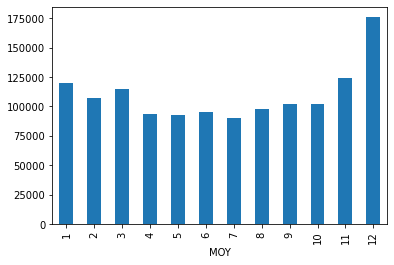

In [12]:
temp.groupby('MOY').item_cnt_month.mean().plot(kind='bar')

<br>
<hr>
<br>

## Project into items space

How many times we see each item in data set

In [13]:
item_appearances = agg_sales.groupby(level=2).item_cnt_month.count().sort_values()

In [14]:
item_appearances.head(10)

item_id
0       1
7509    1
7523    1
7537    1
7546    1
7547    1
7549    1
7550    1
7553    1
7555    1
Name: item_cnt_month, dtype: int64

In [15]:
(item_appearances == 1).sum()

2521

There are > 2000 items that we only see once! I need a feature to capture this.

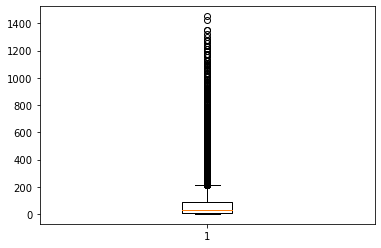

In [16]:
plt.boxplot(item_appearances);

Looks at num sales distribution accross items

In [17]:
aggregated_sales_per_item = agg_sales.groupby(level=2).item_cnt_month.sum()

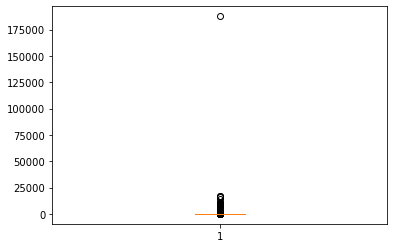

In [18]:
plt.boxplot(aggregated_sales_per_item);

In [19]:
aggregated_sales_per_item.sort_values()

item_id
1590        -11.0
13474        -1.0
11871        -1.0
18062        -1.0
13477         0.0
           ...   
5822      14515.0
17717     15830.0
3732      16642.0
2808      17245.0
20949    187642.0
Name: item_cnt_month, Length: 21807, dtype: float64

In [20]:
agg_sales.loc[pd.IndexSlice[:,:,20949], :].sort_values(by='item_cnt_month')

,,,item_cnt_month,item_price
Month,shop_id,item_id,,
2013-04,3,20949,1.0,5.000000
2015-09,2,20949,1.0,5.000000
2015-08,45,20949,1.0,5.000000
2015-07,52,20949,1.0,5.000000
2015-01,41,20949,1.0,5.000000
...,...,...,...,...
2014-12,25,20949,997.0,4.999769
2015-01,12,20949,1000.0,4.000000
2013-12,25,20949,1066.0,5.000000


In [21]:
items.query('item_id == 20949').item_name.values

array(['Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм'],
      dtype=object)

google says: 'Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм' -->'Branded jersey package 1C Interest white (34/42) 45 microns'

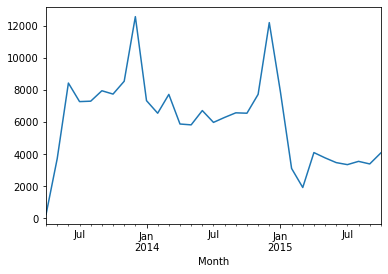

In [22]:
agg_sales.loc[pd.IndexSlice[:,:,20949], :].groupby(level=0).item_cnt_month.sum().plot()

Seems like a seasonal - winter vs summer thing

Perhaps I should create a feature for this specific item since it is sold so much more than anything else

<br>
<hr>
<br>

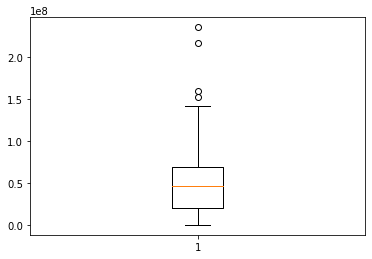

In [23]:
profit_per_shop = agg_sales.groupby(level=[0,1]).apply(lambda x: (x.item_cnt_month*x.item_price).sum()).unstack(level=1).fillna(0)
plt.boxplot(profit_per_shop.sum().sort_values());

In [24]:
item_life = pd.concat([agg_sales.reset_index().groupby('item_id').Month.min().rename('First'),
          agg_sales.reset_index().groupby('item_id').Month.max().rename('Last')], axis=1)

In [25]:
num_months = (item_life.Last - item_life.First).apply(lambda x: x.n + 1)

In [26]:
num_months.describe()

count    21807.000000
mean        14.046270
std          9.962316
min          1.000000
25%          5.000000
50%         13.000000
75%         21.000000
max         34.000000
dtype: float64

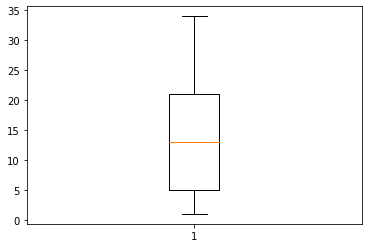

In [27]:
plt.boxplot(num_months);

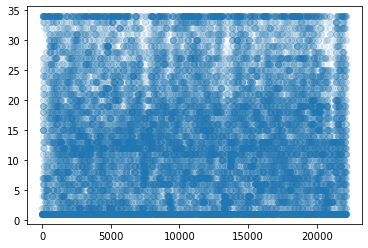

In [28]:
plt.scatter(num_months.index, num_months.values, alpha=0.1)

<br>
<hr>
<br>


Are lower priced items sold consistently more than higher priced items?

In [29]:
agg_sales.head()

item_cnt_month  item_price
Month   shop_id item_id                            
2013-01 0       32                  6.0       221.0
                33                  3.0       347.0
                35                  1.0       247.0
                43                  1.0       221.0
                51                  2.0       128.5

In [30]:
agg_sales_and_price = agg_sales.groupby(level=[0,2]).agg({'item_cnt_month':sum, 'item_price':max})

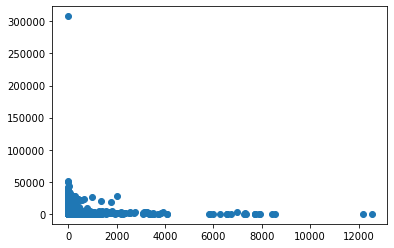

In [31]:
plt.scatter(agg_sales_and_price.item_cnt_month, agg_sales_and_price.item_price)

Is that one an outlier?

In [32]:
agg_sales.sort_values(by='item_price')

item_cnt_month     item_price
Month   shop_id item_id                               
2013-07 6       11872               1.0       0.090000
2013-06 58      11865               4.0       0.090000
        6       11864               7.0       0.094000
        58      20146               6.0       0.095833
        31      11872               8.0       0.100000
...                                 ...            ...
2015-10 22      13403               1.0   42990.000000
        3       13403               1.0   42990.000000
2015-01 12      7241                1.0   49782.000000
2014-03 25      13199               1.0   50999.000000
2013-12 12      6066                1.0  307980.000000

[1609124 rows x 2 columns]

In [33]:
items.query('item_id == 6066')

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


google says: 'Radmin 3 - 522 лиц' --> 'Radmin 3 - 522 persons'   

In [34]:
categories.query('item_category_id == 75')

,item_category_name,item_category_id
75,Программы - Для дома и офиса,75


google says: 'Программы - Для дома и офиса' --> 'Programs - For home and office'

In [35]:
idx_slice = pd.IndexSlice

In [36]:
agg_sales.loc[idx_slice[:,:,6066], :]

,,,item_cnt_month,item_price
Month,shop_id,item_id,,
2013-12,12,6066,1.0,307980.0


In [37]:
(test_set.item_id == 6066).any()

False

Only appears once, does not appear in test set - seems like an outlier; will drop

In [38]:
items.query('item_id == 13199')

,item_name,item_id,item_category_id
13199,Коллекционные шахматы (Властелин Колец),13199,69


google says: 'Коллекционные шахматы (Властелин Колец)' --> 'Collective Chess (Lord of the Rings)'

In [39]:
categories.query('item_category_id == 69')

,item_category_name,item_category_id
69,Подарки - Сувениры,69


google says: 'Подарки - Сувениры	' --> 'Gifts - Souvenirs'

In [40]:
idx_slice = pd.IndexSlice

In [41]:
agg_sales.loc[idx_slice[:,:,13199], :]

,,,item_cnt_month,item_price
Month,shop_id,item_id,,
2014-03,25,13199,1.0,50999.0


In [42]:
(test_set.item_id == 13199).any()

False

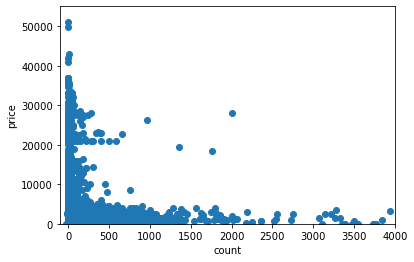

In [43]:
fig, ax = plt.subplots(1,1)
ax.scatter(agg_sales_and_price.item_cnt_month, agg_sales_and_price.item_price)
ax.set_xlim(-100, 4_000)
ax.set_ylim(0, 55_000)
ax.set_ylabel('price')
ax.set_xlabel('count');

No significant correlation

In [44]:
agg_sales_and_price.corr()

,item_cnt_month,item_price
item_cnt_month,1.000000,0.030912
item_price,0.030912,1.000000


Now Drop the outlier identified above

In [45]:
agg_sales = agg_sales.drop(6066, level=2)

In [46]:
agg_sales_and_price = agg_sales.groupby(level=[0,2]).agg({'item_cnt_month':sum, 'item_price':max})

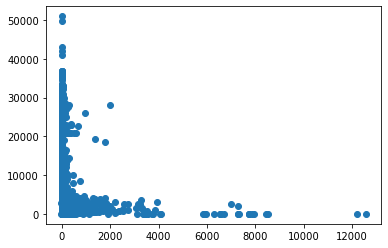

In [47]:
plt.scatter(agg_sales_and_price.item_cnt_month, agg_sales_and_price.item_price)

## Explore categories

In [48]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [49]:
categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [50]:
items_per_category = items.groupby('item_category_id').item_id.nunique().sort_values()

In [51]:
items_per_category.head()

item_category_id
79    1
10    1
51    1
1     2
50    2
Name: item_id, dtype: int64

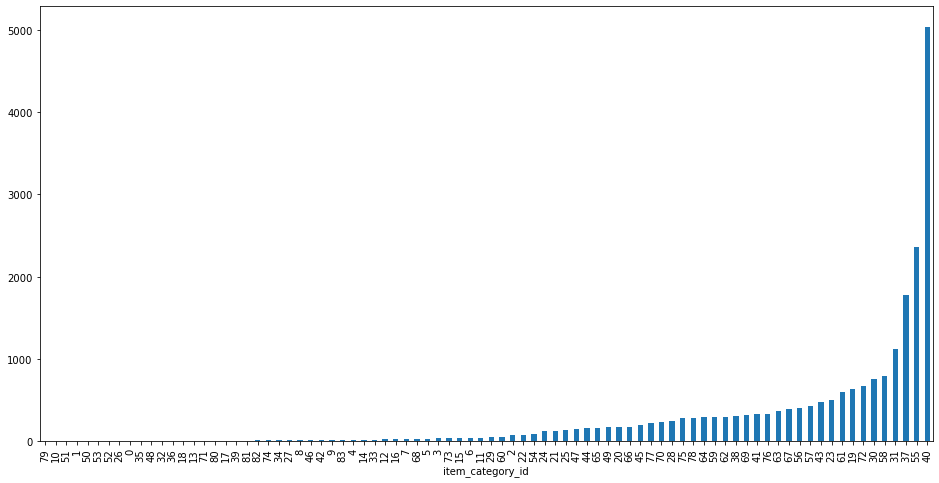

In [52]:
items_per_category.plot(kind='bar',  figsize=(16,8));

lets look at bigest category and see how sales are ditributed for items in that category

In [53]:
cat40_items = items.query('item_category_id == 40').item_id.values

In [54]:
idx = agg_sales.reset_index().item_id.isin(cat40_items)
subset = agg_sales.loc[idx.values]

In [55]:
subset.groupby(level=2).item_cnt_month.sum().describe()

count    4964.000000
mean      127.754029
std       257.226029
min         1.000000
25%        13.000000
50%        45.500000
75%       114.000000
max      3563.000000
Name: item_cnt_month, dtype: float64

It is a wide distribution

In [56]:
categories.query('item_category_id == 40')

,item_category_name,item_category_id
40,Кино - DVD,40


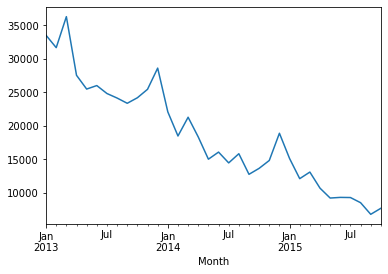

In [57]:
subset.groupby(level=0).item_cnt_month.sum().plot()

No suprise here - DVD sales have defenitely gone down recently

lets look second biggest category and see how sales are ditributed for items in that category

In [58]:
cat55_items = items.query('item_category_id == 55').item_id.values

In [59]:
idx = agg_sales.reset_index().item_id.isin(cat55_items)
subset = agg_sales.loc[idx.values]

In [60]:
subset.groupby(level=2).item_cnt_month.sum().describe()

count    2327.000000
mean      149.802750
std       233.988183
min         1.000000
25%        17.000000
50%        69.000000
75%       186.000000
max      2797.000000
Name: item_cnt_month, dtype: float64

It is a wide distribution

In [61]:
categories.query('item_category_id == 55')

,item_category_name,item_category_id
55,Музыка - CD локального производства,55


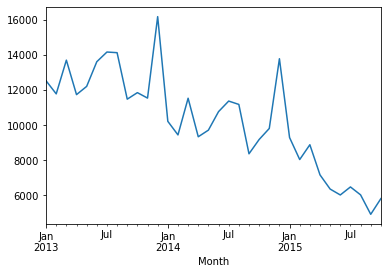

In [62]:
subset.groupby(level=0).item_cnt_month.sum().plot();

In [63]:
agg_sales

item_cnt_month  item_price
Month   shop_id item_id                            
2013-01 0       32                  6.0       221.0
                33                  3.0       347.0
                35                  1.0       247.0
                43                  1.0       221.0
                51                  2.0       128.5
...                                 ...         ...
2015-10 59      22087               6.0       119.0
                22088               2.0       119.0
                22091               1.0       179.0
                22100               1.0       629.0
                22102               1.0      1250.0

[1609123 rows x 2 columns]

In [135]:
cat_annotated_agg_sales = (pd.merge(agg_sales.reset_index(), items.drop('item_name', axis=1), on='item_id')
                           .set_index(['Month', 'shop_id', 'item_id'])
                           .sort_index(level=[0,1,2])
                          )

In [136]:
cat_annotated_agg_sales.head()

item_cnt_month  item_price  item_category_id
Month   shop_id item_id                                              
2013-01 0       32                  6.0       221.0                40
                33                  3.0       347.0                37
                35                  1.0       247.0                40
                43                  1.0       221.0                40
                51                  2.0       128.5                57

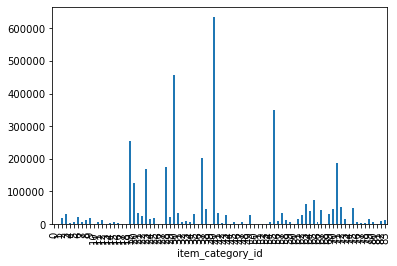

In [66]:
cat_annotated_agg_sales.groupby('item_category_id').item_cnt_month.sum().plot(kind='bar')

## Explore Shops

In [308]:
from sklearn.manifold import TSNE

In [106]:
piv_agg_sales.head()

Month            2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  \
shop_id item_id                                                         
0       30           0.0     31.0      0.0      0.0      0.0      0.0   
        31           0.0     11.0      0.0      0.0      0.0      0.0   
        32           6.0     10.0      0.0      0.0      0.0      0.0   
        33           3.0      3.0      0.0      0.0      0.0      0.0   
        35           1.0     14.0      0.0      0.0      0.0      0.0   

Month            2013-07  2013-08  2013-09  2013-10  ...  2015-01  2015-02  \
shop_id item_id                                      ...                     
0       30           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        31           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        32           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        33           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        35           0.0      0.0      0.0      0.0  ...      0.0      0.0   

Month            2015-03  2015-04  2015-05  2015-06  2015-07  2015-08  \
shop_id item_id                                                         
0       30           0.0      0.0      0.0      0.0      0.0      0.0   
        31           0.0      0.0      0.0      0.0      0.0      0.0   
        32           0.0      0.0      0.0      0.0      0.0      0.0   
        33           0.0      0.0      0.0      0.0      0.0      0.0   
        35           0.0      0.0      0.0      0.0      0.0      0.0   

Month            2015-09  2015-10  
shop_id item_id                    
0       30           0.0      0.0  
        31           0.0      0.0  
        32           0.0      0.0  
        33           0.0      0.0  
        35           0.0      0.0  

[5 rows x 34 columns]

In [255]:
shop_profits = agg_sales.groupby(level=[0,1]).apply(lambda x: (x.item_cnt_month*x.item_price).sum()).unstack(level=0).fillna(0)

In [258]:
shop_profits.head()

Month,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
shop_id,,,,,,,,,,,,,,,,,,,,,
0,2.966061e+06,3.670881e+06,0.000000e+00,0.00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
1,1.527037e+06,1.710796e+06,0.000000e+00,0.00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
2,1.086138e+06,5.231761e+05,7.378355e+05,615004.60,542550.839881,8.278706e+05,863821.975000,8.928124e+05,1.326312e+06,1.086280e+06,...,1.415131e+06,9.997728e+05,1.053243e+06,1.273795e+06,1.476925e+06,1.107731e+06,988213.915556,993776.530727,1.343664e+06,1.261611e+06
3,5.605850e+05,5.840684e+05,6.360329e+05,399608.00,470726.936364,5.208006e+05,542202.743590,5.482862e+05,1.023652e+06,7.633430e+05,...,1.226842e+06,9.025977e+05,9.560844e+05,9.611462e+05,1.147409e+06,6.770385e+05,672666.227500,753629.104667,9.532984e+05,8.160634e+05
4,1.434960e+06,1.538995e+06,1.418166e+06,202574.75,917468.718750,1.201301e+06,977240.514167,1.162317e+06,1.426126e+06,1.396139e+06,...,1.242995e+06,1.059563e+06,9.912013e+05,9.681878e+05,9.792854e+05,6.910144e+05,721250.933182,747325.038333,6.651101e+05,7.675972e+05


In [291]:
tsne = TSNE(perplexity=4).fit_transform(shop_profits)

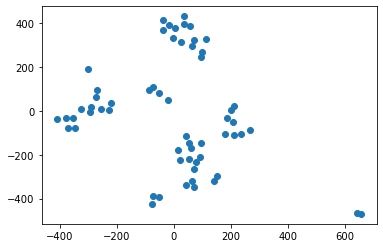

In [292]:
plt.scatter(tsne[:,0], tsne[:,1])

In [300]:
agg_sales

item_cnt_month  item_price
Month   shop_id item_id                            
2013-01 0       32                  6.0       221.0
                33                  3.0       347.0
                35                  1.0       247.0
                43                  1.0       221.0
                51                  2.0       128.5
...                                 ...         ...
2015-10 59      22087               6.0       119.0
                22088               2.0       119.0
                22091               1.0       179.0
                22100               1.0       629.0
                22102               1.0      1250.0

[1609124 rows x 2 columns]

In [306]:
shops_categories = pd.merge(agg_sales.reset_index(), items[['item_id','item_category_id']], on='item_id').groupby(['shop_id','item_category_id']).item_cnt_month.sum().unstack(level=0).fillna(0)

In [307]:
shops_categories

shop_id,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
item_category_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,105.0,63.0,355.0,200.0,309.0,232.0,422.0,491.0,19.0,32.0,...,733.0,231.0,250.0,341.0,874.0,0.0,338.0,669.0,324.0,223.0
3,52.0,18.0,527.0,360.0,333.0,340.0,755.0,554.0,0.0,71.0,...,773.0,247.0,376.0,460.0,1098.0,0.0,472.0,965.0,574.0,399.0
4,38.0,30.0,42.0,28.0,101.0,38.0,21.0,92.0,2.0,0.0,...,92.0,56.0,55.0,68.0,103.0,0.0,46.0,149.0,80.0,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.0,0.0,222.0,252.0,501.0,309.0,639.0,689.0,1.0,14.0,...,171.0,0.0,261.0,360.0,332.0,0.0,225.0,235.0,188.0,345.0
80,0.0,0.0,0.0,99.0,5.0,26.0,62.0,25.0,0.0,0.0,...,13.0,0.0,2.0,8.0,0.0,12.0,81.0,0.0,0.0,30.0
81,44.0,28.0,2.0,0.0,31.0,0.0,52.0,0.0,0.0,0.0,...,0.0,109.0,24.0,0.0,51.0,0.0,47.0,81.0,36.0,0.0


In [329]:
from sklearn.decomposition import PCA

In [335]:
pca = PCA(n_components=20).fit(shops_categories)

In [336]:
pca.explained_variance_

array([3.51288597e+08, 1.70897264e+07, 1.57195731e+07, 4.35850797e+06,
       2.99282916e+06, 1.71523243e+06, 1.24041374e+06, 8.59415832e+05,
       5.61582164e+05, 4.58240656e+05, 3.03408533e+05, 2.37597331e+05,
       2.04918466e+05, 1.50751661e+05, 1.31705431e+05, 8.89696724e+04,
       6.35857861e+04, 4.78245293e+04, 4.36940412e+04, 3.57731561e+04])

## Explore test set

In [67]:
test_set[['shop_id', 'item_id']].nunique()

shop_id      42
item_id    5100
dtype: int64

In [68]:
test_set.groupby('shop_id').item_id.nunique()

shop_id
2     5100
3     5100
4     5100
5     5100
6     5100
7     5100
10    5100
12    5100
14    5100
15    5100
16    5100
18    5100
19    5100
21    5100
22    5100
24    5100
25    5100
26    5100
28    5100
31    5100
34    5100
35    5100
36    5100
37    5100
38    5100
39    5100
41    5100
42    5100
44    5100
45    5100
46    5100
47    5100
48    5100
49    5100
50    5100
52    5100
53    5100
55    5100
56    5100
57    5100
58    5100
59    5100
Name: item_id, dtype: int64

When performing validation, I must do it over a set that looks like this: same items for all shops (but not the full universe of items).

I am creating such data frame now, that will be used to calculate error.

In [7]:
def create_submission_like_df():
    months = sorted(agg_sales.index.levels[0])
    submission_like_data  = {}
    for month in months:    
        month_data = agg_sales.loc[month]
        shops = set(month_data.index.get_level_values(0))
        item_ids = set(month_data.index.get_level_values(1))

        new_idx = pd.Index(product(shops, item_ids), name=month_data.index.name)
        submission_like_data[month] = month_data.reindex(new_idx).fillna({'item_cnt_month':0, 'item_price':-1})
        
    submission_like_df = pd.concat(submission_like_data)
    submission_like_df.index.names = agg_sales.index.names
    
    return submission_like_df

In [9]:
%%time
submission_like_df = create_submission_like_df()

Wall time: 21.4 s


In [14]:
submission_like_df.loc[agg_sales.index.levels[0][0]].reset_index().groupby('shop_id').item_id.nunique().head(10)

shop_id
0     8115
1     8115
2     8115
3     8115
4     8115
6     8115
7     8115
8     8115
10    8115
12    8115
Name: item_id, dtype: int64

<hr>
<hr>
<hr>